In [180]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [181]:
import numpy
import torch
import typing

from holo.prettyFormats import prettyPrint

In [164]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")

using device: cuda:0


In [206]:
import handleDatas
import train
import moe_model
import basicModels

def cell():
    global handleDatas, train, moe_model, basicModels
    import importlib
    handleDatas = importlib.reload(handleDatas)
    train = importlib.reload(train)
    moe_model = importlib.reload(moe_model)
    basicModels = importlib.reload(basicModels)

cell();

In [184]:
#datashandler = handleDatas.Cifar100_Datas(
#    fromTrainSource=None, maxSamples=None, trainProp=0.8,
#    batchSizeTrain=256, batchSizeTest=256)

datashandler = handleDatas.HandleImagesClassifDatas.merge(
    #handleDatas.MNIST_Datas(
    #    fromTrainSource=None, maxSamples=None, trainProp=0.8, batchSizeTrain=256, batchSizeTest=256),
    #handleDatas.FashionMNIST_Datas(
    #    fromTrainSource=None, maxSamples=None, trainProp=0.8, batchSizeTrain=256, batchSizeTest=256),
    handleDatas.Cifar10_Datas(
        fromTrainSource=None, maxSamples=None, trainProp=0.8, batchSizeTrain=256, batchSizeTest=256),
    handleDatas.Cifar100_Datas(
        fromTrainSource=None, maxSamples=None, trainProp=0.8, batchSizeTrain=256, batchSizeTest=256),
    trainProp=0.8, batchSizeTrain=256, batchSizeTest=256)

loaded Cifar10(total: 60000), train: 48000 [188 batches] | test: 12000 [47 batches]
loaded Cifar100(total: 60000), train: 48000 [188 batches] | test: 12000 [47 batches]
loaded Merged[Cifar10, Cifar100](total: 120000), train: 96000 [375 batches] | test: 24000 [94 batches]


In [186]:
model, optim, loss = basicModels.BasicImageClassifModel.get_Cifar_like_32x32x3(
    device=device, nbClasses=datashandler.nbClasses, modelConfig="medium")
hist = train.HistoryClassification()
basicModels.countLayersparameters(model)

# test the model
_ = model(datashandler.full_dataset[0]['image'].to(device))

+----------------------+------------+
|       Modules        | Parameters |
+----------------------+------------+
| CNN_block1.0.weight  |    432     |
| CNN_block2.0.weight  |   4_608    |
| CNN_block2.1.weight  |     32     |
|  CNN_block2.1.bias   |     32     |
| CNN_block3.0.weight  |   9_216    |
| CNN_block4.0.weight  |   18_432   |
| CNN_block5.0.weight  |   73_728   |
| CNN_block6.0.weight  |  294_912   |
| CNN_block6.1.weight  |    256     |
|  CNN_block6.1.bias   |    256     |
| outputBlock.2.weight |  450_560   |
|  outputBlock.2.bias  |    110     |
+----------------------+------------+
Total Trainable Params: 852_574


In [187]:
train.train_model_classif(
    model=model, optimizer=optim, criterion=loss, device=device,
    datasHandler=datashandler, nbEpoches=10, history=hist);

Epoch 1, train: (loss: 3.142, accuracy: 27.23%), test: (loss: 2.528, accuracy: 37.79%), lr: 1.0000e-03
Epoch 2, train: (loss: 2.242, accuracy: 44.06%), test: (loss: 2.191, accuracy: 45.26%), lr: 1.0000e-03
Epoch 3, train: (loss: 1.875, accuracy: 51.79%), test: (loss: 2.195, accuracy: 46.54%), lr: 1.0000e-03
Epoch 4, train: (loss: 1.619, accuracy: 57.39%), test: (loss: 1.775, accuracy: 54.52%), lr: 1.0000e-03
Epoch 5, train: (loss: 1.434, accuracy: 61.44%), test: (loss: 1.749, accuracy: 54.97%), lr: 1.0000e-03
Epoch 6, train: (loss: 1.265, accuracy: 65.40%), test: (loss: 1.632, accuracy: 57.16%), lr: 1.0000e-03
Epoch 7, train: (loss: 1.115, accuracy: 68.91%), test: (loss: 1.588, accuracy: 59.25%), lr: 1.0000e-03
Epoch 8, train: (loss: 0.9892, accuracy: 71.92%), test: (loss: 1.557, accuracy: 60.37%), lr: 1.0000e-03
Epoch 9, train: (loss: 0.8804, accuracy: 74.69%), test: (loss: 1.639, accuracy: 59.51%), lr: 1.0000e-03
Epoch 10, train: (loss: 0.7798, accuracy: 77.18%), test: (loss: 1.636, 

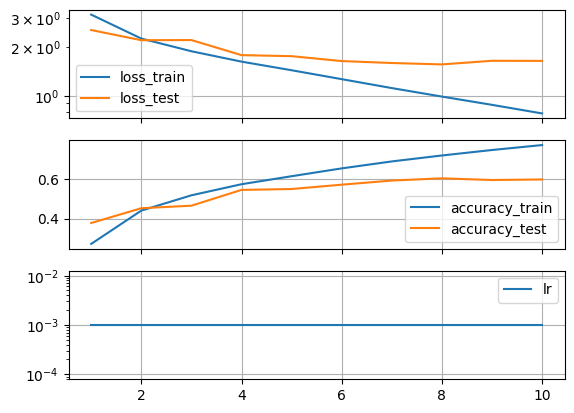

In [188]:
hist.plot();

In [199]:
def cell():
    conf = hist[-1].test.confusionMatrix
    print(conf.matrix[0, :].T)
    print(conf.matrix[65, 65], conf.matrix[65, :])
    
    with numpy.printoptions(threshold=100_000, linewidth=100_000):
        print(conf.matrix)
    print()

    for clsIndex in range(datashandler.nbClasses):
        print(f"class: {clsIndex}, precision:{conf.classPrecision(clsIndex):.2%}, "
              f"hitRate: {conf.classHitRate(clsIndex):.2%}")
    print()
    
    prettyPrint(conf.worstK_confusions(10), 
                specificCompact={tuple}, specificFormats={numpy.float64:lambda x:f"{x:.4g}"})
cell(); del cell

[908   1  44  15  11   6   5  13  41  14   1   4   1   3   3   1   2   2
   3   0   2   0  10   2   5   2   1   1   4   2   2   0   0   6   3   2
   3   8   2   4   7   2   1   0   1   1   0   0   0   1   1   2   1   0
  11   0   2   1   2   4   1   1   1   0   2   3   1   1   0   2   0   0
   0   0   0   0   3   4   1   6   0   6   4   7   2   2   0   0   1   3
   0   1   0   1   3   7   1   2   0   2   6  10   1   4   0  14   0   1
   0   1]
11 [ 3  0  1  2  3  0  0  1  0  0  0  0  0  1  3  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  1  0  0  0  1  0  0  0  0  0  0  0  0  0  0  1  0  1  0
  0  0  0  0  0  0  0  1  0  0  0  0  1  1  0  0  0 11  0  0  0  0  0  0
  0  0  0  1  0  0  0  0  0  0  3  0  2  1  0  2  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  1  0  0  0  1]
[[ 908    1   44   15   11    6    5   13   41   14    1    4    1    3    3    1    2    2    3    0    2    0   10    2    5    2    1    1    4    2    2    0    0    6    3    2    3    8    2    4    7    2  